# Differentiable Simulation of Detailed Neuron Morphologies
Author: Christian Pehle


In [1]:
import jax.numpy as np
import tree_math
import dataclasses

from jaxsnn.base import funcutils
from jaxsnn.base import implicit
from jaxsnn.base.tree_solver import tree_solve, tree_matmul
from jaxsnn.base.types import ArrayLike

import jaxsnn.morph.generate_morphologies as gm
import matplotlib.pyplot as plt

In [ ]:
@tree_math.struct
class HodgekinHuxleyState:
    v: ArrayLike
    m: ArrayLike
    h: ArrayLike
    n: ArrayLike


@tree_math.struct
class HodgekinHuxleyParameters:
    g_K: ArrayLike
    E_K: ArrayLike
    g_Na: ArrayLike
    E_Na: ArrayLike
    g_L: ArrayLike
    E_L: ArrayLike
    C_m_inv: ArrayLike

In [ ]:
def channel_dynamics(alpha, beta):
    def dynamics(x: ArrayLike, v: ArrayLike):
        return alpha(v) * (1 - x) - beta(v) * x

    return dynamics

In [ ]:
def alpha_n(Vm):
    return (0.02 * (Vm - 25.0)) / (1.0 - np.exp((-1.0 * (Vm - 25.0)) / 9.0))


def beta_n(Vm):
    return (-0.002 * (Vm - 25.0)) / (1.0 - np.exp((Vm - 25.0) / 9.0))


def alpha_m(Vm):
    return (0.182 * (Vm + 35.0)) / (1.0 - np.exp((-1.0 * (Vm + 35.0)) / 9.0))


def beta_m(Vm):
    return (-0.124 * (Vm + 35.0)) / (1.0 - np.exp((Vm + 35.0) / 9.0))


def alpha_h(Vm):
    return 0.25 * np.exp((-1.0 * (Vm + 90.0)) / 12.0)


def beta_h(Vm):
    return (0.25 * np.exp((Vm + 62.0) / 6.0)) / np.exp((Vm + 90.0) / 12.0)

In [ ]:
def x0(alpha, beta):
    def x0(v):
        return alpha(v) / (alpha(v) + beta(v))

    return x0


h0 = x0(alpha_h, beta_h)
n0 = x0(alpha_n, beta_n)
m0 = x0(alpha_m, beta_m)

In [ ]:
def I_Na(s: HodgekinHuxleyState, p: HodgekinHuxleyParameters):
    return p.g_Na * np.power(s.m, 3) * s.h * (s.v - p.E_Na)


def I_K(s: HodgekinHuxleyState, p: HodgekinHuxleyParameters):
    return p.g_K * np.power(s.n, 4) * (s.v - p.E_K)


def I_L(s: HodgekinHuxleyState, p: HodgekinHuxleyParameters):
    return p.g_L * (s.v - p.E_L)


def hodgekin_huxley_dynamics(p: HodgekinHuxleyParameters):
    m_dynamics = channel_dynamics(alpha_m, beta_m)
    h_dynamics = channel_dynamics(alpha_h, beta_h)
    n_dynamics = channel_dynamics(alpha_n, beta_n)

    def dynamics(s: HodgekinHuxleyState, I: ArrayLike):
        return HodgekinHuxleyState(
            v=-p.C_m_inv * (I_K(s, p) + I_Na(s, p) + I_L(s, p) - I),
            m=m_dynamics(s.m, s.v),
            n=n_dynamics(s.n, s.v),
            h=h_dynamics(s.h, s.v),
        )

    return dynamics

In [2]:
@tree_math.struct
class NeuronState:
    v: ArrayLike
    I: ArrayLike


@dataclasses.dataclass
class MultiCompartmentNeuronModel(implicit.ImplicitExplicitODE):
    d: ArrayLike
    u: ArrayLike
    p: ArrayLike

    def explicit_terms(self, state):
        return NeuronState(v=state.I, I=-20 * state.I)

    def implicit_terms(self, state):
        return NeuronState(
            v=tree_matmul(self.d, self.u, self.p, state.v), I=np.zeros_like(state.I)
        )

    def implicit_solve(self, state, step_size):
        return NeuronState(
            v=tree_solve(1 - step_size * self.d, -step_size * self.u, self.p, state.v),
            I=state.I,
        )

In [12]:
import numpy as onp

morph = gm.swc_geometry(
    "../../data/morphologies/allen/Cux2-CreERT2_Ai14-211772.05.02.01_674408996_m.swc"
)
tm = gm.compute_tree_matrix(morph)


N = len(tm.d)
dt = 0.1
inner_steps = 1
outer_steps = 2048
time = dt * inner_steps * (1 + np.arange(outer_steps))

equation = MultiCompartmentNeuronModel(d=tm.d, u=tm.u, p=tm.p)

semi_implicit_step = implicit.imex_rk_sil3(equation, dt)
integrator = funcutils.trajectory(
    funcutils.repeated(semi_implicit_step, inner_steps), outer_steps
)

initial_state = NeuronState(v=np.sin(np.linspace(0, 5, N)), I=np.zeros(N))
_, actual = integrator(initial_state)

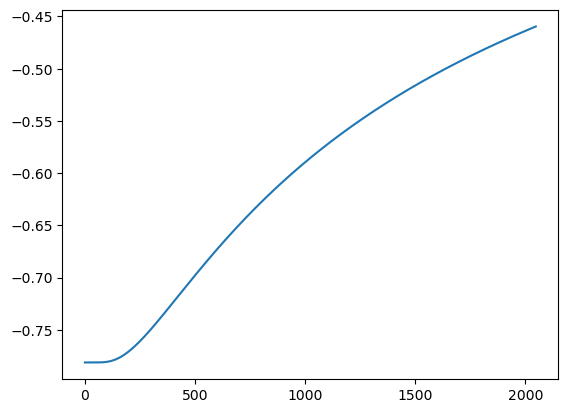

In [30]:
np.min(actual.v), np.max(actual.v), np.max(actual.v[-1]), np.min(actual.v[-1])

In [4]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm


def plot_morphology(ax, morph, colors=None):
    nb = morph.num_branches

    min_x = 0
    max_x = 1
    min_y = 0
    max_y = 1

    lines = []
    idx = 0

    for i in range(nb):
        segs = morph.branch_segments(i)
        xs = []
        ys = []

        for seg in segs:
            xs.append(seg.prox.x)
            xs.append(seg.dist.x)
            ys.append(seg.prox.y)
            ys.append(seg.dist.y)
            lines.append(Line2D(xs, ys, c=cm.viridis(colors[idx])))

            idx = idx + 1

        min_x = min(min_x, min(xs))
        max_x = max(max_x, max(xs))
        min_y = min(min_y, min(ys))
        max_y = max(max_y, max(ys))

    for line in lines:
        ax.add_line(line)

    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)

In [5]:
import matplotlib as mpl
import matplotlib.animation as animation


def animate_fig(filename, n_frames=300):
    fig, ax = plt.subplots(figsize=(10, 10))
    norm = mpl.colors.Normalize(vmin=np.min(actual.v), vmax=np.max(actual.v))

    step = 0
    ax.set_axis_off()

    print(actual.v[step].shape)
    plot_morphology(ax, morph, colors=onp.array(actual.v[step]))
    fig.tight_layout()

    def update(step):
        ax.clear()
        ax.set_axis_off()
        plot_morphology(ax, morph, colors=onp.array(actual.v[step]))
        fig.tight_layout()
        return ax

    ani = animation.FuncAnimation(
        fig, update, frames=np.arange(0, n_frames, 1), interval=100
    )
    ani.save(filename, writer="ffmpeg", fps=30)

(7430,)


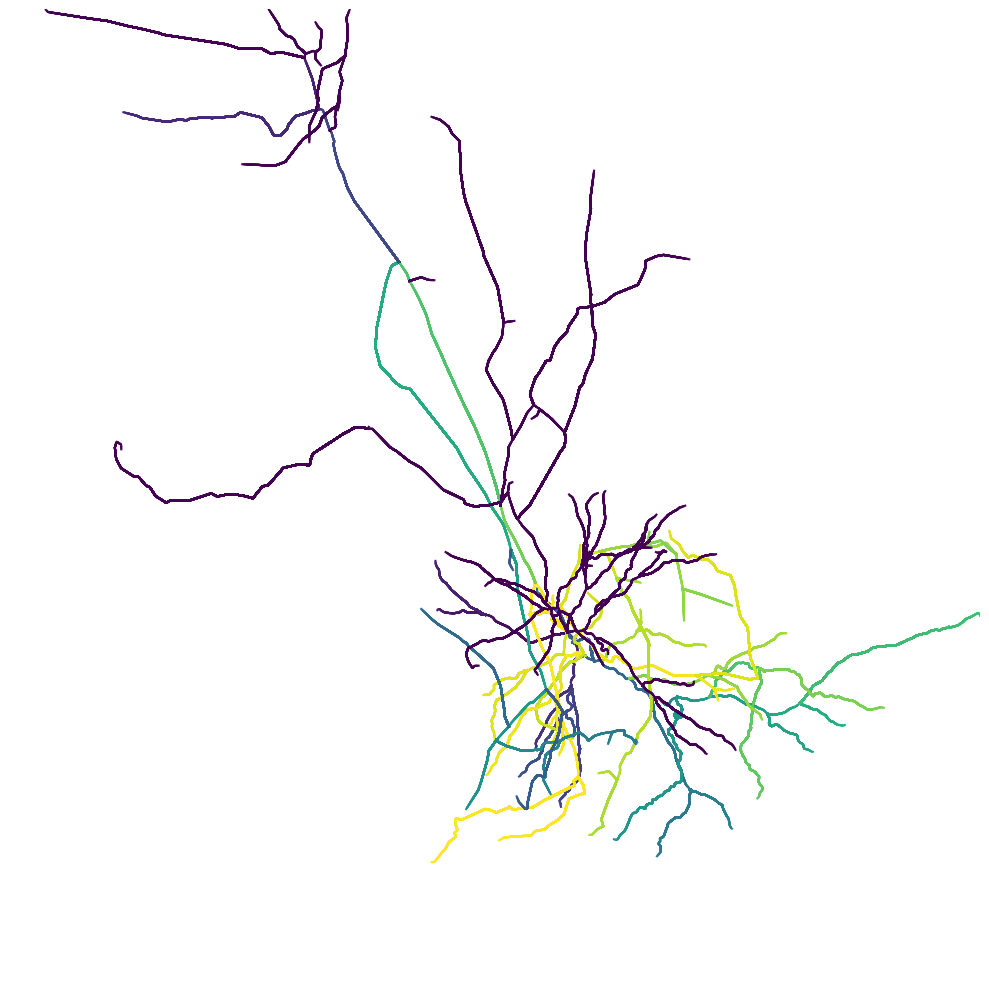

In [7]:
animate_fig(filename="test.gif", n_frames=300)